# Dog races detection with CNNs and Transfer Learning

# Introduction

In this project, we will use *Tensoflow (Keras)* to implement and train *machine learning* algorithms to automatically detect *dog races* in pictures. 

To solve this problematic, we will create a *CNN (Convulotionnal Neural Network)* from scratch, and *fine-tune pre-trained models* thanks to *transfer learning*. We will use *KerasTuner* for the hyperparameters search and *Tensorboard* to track the *results*.

The *training data* used in this notebook is the [*Standford Dogs Dataset*](http://vision.stanford.edu/aditya86/ImageNetDogs/).

# Environment

Import libraries:

In [1]:
# import plotly
import copy
import pandas as pd
import numpy as np
import tensorboard
from mat4py import loadmat
from IPython.display import Image
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tensorflow.python.summary.summary_iterator import summary_iterator
import keras_tuner as kt
import matplotlib.pyplot as plt
from IPython.display import IFrame

Delete the *(previous) TensorBoard* logs:

In [2]:
# Clear any logs from previous runs
! rm -rf cnn_log
! rm -rf vgg_log
! rm -rf inception_log
! rm -rf untitled_project
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Set Seeds

*For reproductibility*

In [3]:
seed = 999
np.random.seed(seed)
tf.random.set_seed(seed)

# Load Meta Data

In order to obtain the file paths for our training and testing dataset, we use the meta data and open the *file lists* with *loadmat*:

In [4]:
# Load meta data
train_df_init = pd.DataFrame(loadmat('./data/lists/train_list.mat'))
val_df_init = pd.DataFrame(loadmat('./data/lists/test_list.mat'))
train_df_init.shape, val_df_init.shape

((12000, 3), (8580, 3))

We obtain a dataset composed of 12000 *training samples* and 8580 *test samples*.

We format the data (*which is encapsulated in lists following our file opening*) in order to use it:

In [5]:
# Clean dataframe
train_df_init = train_df_init.applymap(lambda x: x[0])
val_df_init = val_df_init.applymap(lambda x: x[0])
train_df_init.head()

file_list  \
0   n02085620-Chihuahua/n02085620_5927.jpg   
1   n02085620-Chihuahua/n02085620_4441.jpg   
2   n02085620-Chihuahua/n02085620_1502.jpg   
3   n02085620-Chihuahua/n02085620_1916.jpg   
4  n02085620-Chihuahua/n02085620_13151.jpg   

                       annotation_list  labels  
0   n02085620-Chihuahua/n02085620_5927       1  
1   n02085620-Chihuahua/n02085620_4441       1  
2   n02085620-Chihuahua/n02085620_1502       1  
3   n02085620-Chihuahua/n02085620_1916       1  
4  n02085620-Chihuahua/n02085620_13151       1

The *meta data* contains:
* A *file list*: paths that point to the *image files*,
* An *annotation list*: paths that point the image *annotation files*.
* *labels* which correspond to one the 120 the dog races present in the dataset.

## Extract Labels

We apply a *group by* on the *train set* to extract the *human readable labels*: 

In [6]:
labels_df = train_df_init.groupby('labels').agg(
    race=(
        'file_list', 
        lambda x: x.iloc[0].split('/')[0].split('-')[1].replace('_', ' ').capitalize()))
labels_df

race
labels                     
1                 Chihuahua
2          Japanese spaniel
3               Maltese dog
4                  Pekinese
5                      Shih
...                     ...
116         Standard poodle
117        Mexican hairless
118                   Dingo
119                   Dhole
120     African hunting dog

[120 rows x 1 columns]

# Filter Data

Being limited in *processing power*, we filter our dataset in order to keep a *subset* of the *firsts n (3) classes (N_CLASSES)*:

In [7]:
# Extract first n labels
N_CLASSES = 3


def get_n_classes(train_df, val_df, n_classes):

    train_df = train_df[train_df['labels'] <= n_classes]
    val_df = val_df[val_df['labels'] <= n_classes]

    return train_df, val_df


# We apply the g_n_classes
train_df, val_df = get_n_classes(train_df_init, val_df_init, N_CLASSES)
train_df.shape, val_df.shape

((300, 3), (289, 3))

# Explore Data

The *subset* is composed of 100 *training samples* per race:

In [8]:
# Showi number of samples per labels
train_df['labels'].value_counts()

1    100
2    100
3    100
Name: labels, dtype: int64

This balance is however not found in the *test set*:

In [9]:
val_df['labels'].value_counts()

3    152
2     85
1     52
Name: labels, dtype: int64

We print a *random sample* image:

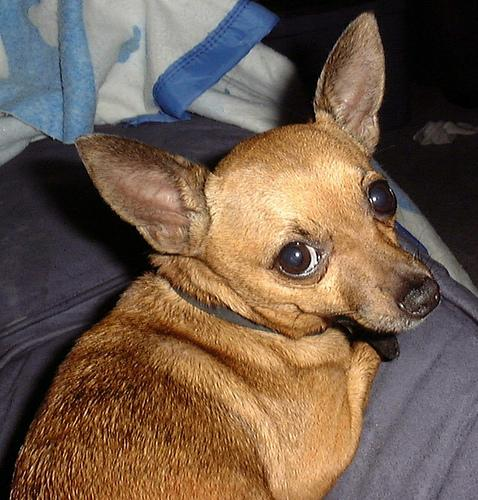

In [10]:
images_path = './data/Images/'

# Show a random picture
sample = train_df.sample(1)
sample_path = images_path + sample['file_list'].values[0]
Image(filename=sample_path)

# Processing and augmentation

## Data Augmentation

In order to experiment with the *processing & augmentation* tools of *Keras*, we have developed a function to show the various transformations:

In [11]:
def show_transformations(sample_path, datagen_settings, n_examples=3):

    sim_generator = ImageDataGenerator(**datagen_settings)

    img = load_img(sample_path)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

    fig = plt.figure(figsize=(25,25))
    plt.subplot(1,4,1)
    plt.title('Original')
    plt.imshow(img)
    plt.axis('off')

    sim_generator.fit(x)
    
    i = 0
    for img in sim_generator.flow(x, batch_size=1):
        plt.subplot(1,4,i+2)
        plt.title(f'Augmented')
        plt.imshow(img[0])
        plt.axis('off')
        i += 1
        if i == n_examples :
            break

By passing the wanted *datagen augmentation settings (as a dictionary)* to the *show_transformation()* function, we can observe the *randomly generated samples*:

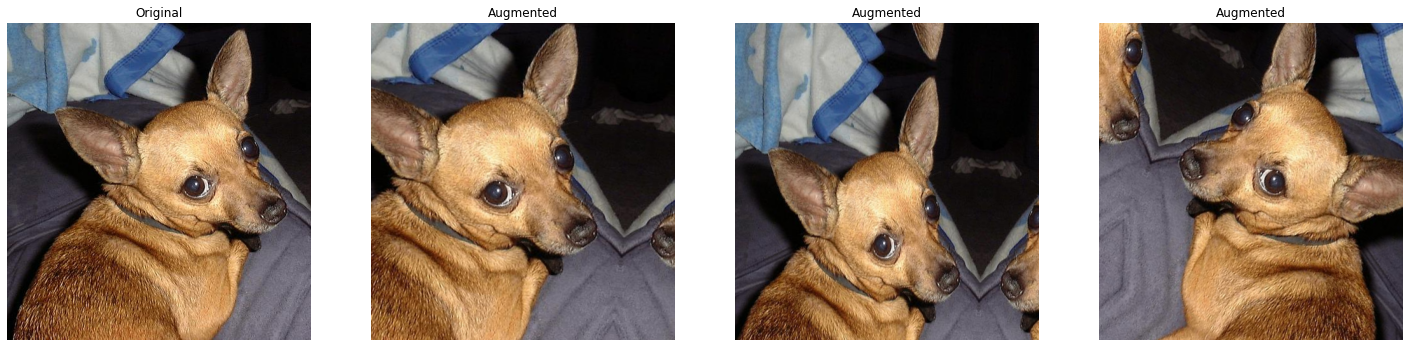

In [12]:
augmentation_settings = dict(
        rescale=1./255.,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect')

show_transformations(
    sample_path=sample_path,
    datagen_settings=augmentation_settings)

By passing the wanted *datagen processing settings (as a dictionary)* to the *show_transformation()* function, we can observe the *randomly generated samples* and limit the output of the function using the *n_examples* parameter:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


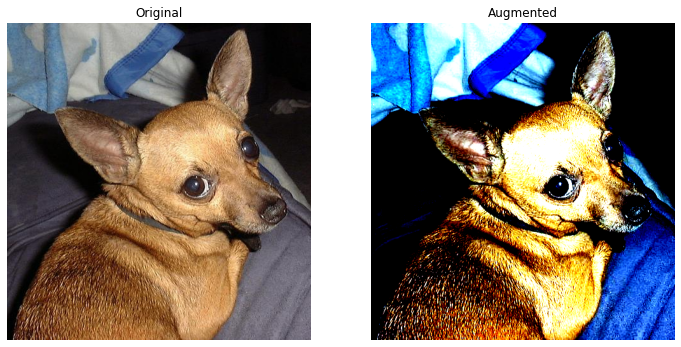

In [13]:
processing_settings = dict(
        rescale=1./255.,
        featurewise_center=True,
        featurewise_std_normalization=True)

show_transformations(
    sample_path=sample_path,
    datagen_settings=processing_settings,
    n_examples=1)

# Preprocessing

Now that we have experimented with the *image processing* and *augmentation* and obtained adequate *parameters*, we will apply these *parameters* on the whole *dataset* in order to train our models.

By using the *flow_from_dataframe* method of the *KerasImageGenerator class*, we will iterate over our *training and testing meta data* to generate *on the fly enhanced and augmented data* to pass to our *model* by *batch*: the *KerasImageGenerator class* is a *python generator*.

* We first format the *dtype* of the *labels* in order to be able to pass it to the *class*:

In [14]:
# Set labels dtype for the generator
train_df['labels'] = train_df['labels'].astype(str)
val_df['labels'] = val_df['labels'].astype(str)

/var/folders/1h/861cc3q97gb3f6r361ydtk9m0000gn/T/ipykernel_7929/3037619370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['labels'] = train_df['labels'].astype(str)
/var/folders/1h/861cc3q97gb3f6r361ydtk9m0000gn/T/ipykernel_7929/3037619370.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['labels'] = val_df['labels'].astype(str)


The *ImageDataGenerator class* has a few drawbacks, including that it is required to first train the *generator* on a *numpy array* containing the images *raw data* before being able to use it to transform the *training data* with tools such as the *standardization*.

* In order to avoid developing a *loop* that would extract the *raw data* from the data directory and only use the *ImageDataGenerator*, we have found a solution that consist of creating a *ImageDataGenerator* with the following *standardize method*:

In [15]:
# https://github.com/keras-team/keras/issues/7218#issuecomment-313364140
class FittedImageDataGenerator(ImageDataGenerator):
    def standardize(self, x):
        if self.featurewise_center:
            x = ((x/255.) - 0.5) * 2.
        return x

*VGG16* is a reknown and standard model in the field of Computer Vision (and one the the algorithms that we will try out in this *notebook*), it was trained with 224x224 pictures, therefore, we are rescaling the dataset pictures to this resolution.

* We initialize our *final settings* as the *datagen_settings dictionary*:

In [16]:
# Define settings for augmentation
datagen_settings = dict(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect',
    featurewise_center=True,
    featurewise_std_normalization=True)

train_datagen = FittedImageDataGenerator(**datagen_settings)
val_datagen = ImageDataGenerator(rescale=1./255.)

We initialize 2 different *generators*: one for the *training set* & one for the *testing set*, in order to avoid *data leak*. 

* We have separate *datasets* for the *training & testing sets*, we therefore do not use a single *generator* nor the *split method* of the *Keras class*:

In [17]:
# Define arguments for both generators
output_dimensions = (224,224)
batch_size = 64
generator_settings = dict(
    directory=images_path,
    x_col='file_list',
    y_col='labels',
    class_mode='categorical',
    target_size=output_dimensions,
    batch_size=batch_size)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    **generator_settings)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    **generator_settings)

Found 300 validated image filenames belonging to 3 classes.
Found 289 validated image filenames belonging to 3 classes.


### *Wrapping it up*

In [18]:
def gen_generators(train_df, val_df, n_classes=3, batch_size=batch_size):    

    train_df, val_df = get_n_classes(train_df_init, val_df_init, n_classes)
    train_df['labels'] = train_df['labels'].astype(str)
    val_df['labels'] = val_df['labels'].astype(str)
    train_datagen = FittedImageDataGenerator(**datagen_settings)
    val_datagen = ImageDataGenerator(rescale=1./255.)
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        **generator_settings)
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        **generator_settings)

    steps_per_epoch = train_df.shape[0] // batch_size
    validation_steps = val_df.shape[0] // batch_size

    return train_generator, val_generator, steps_per_epoch, validation_steps

In [19]:
train_generator, val_generator, steps_per_epoch, validation_steps = gen_generators(train_df_init, val_df_init)

Found 300 validated image filenames belonging to 3 classes.
Found 289 validated image filenames belonging to 3 classes.


/var/folders/1h/861cc3q97gb3f6r361ydtk9m0000gn/T/ipykernel_7929/543202403.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['labels'] = train_df['labels'].astype(str)
/var/folders/1h/861cc3q97gb3f6r361ydtk9m0000gn/T/ipykernel_7929/543202403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['labels'] = val_df['labels'].astype(str)


# CNN from scratch

In order to classify the dog races, we will first build a simple *Convolutional Neural Network (CNN)* to demonstrate how a *CNN* can be built from scratch in *Keras*.

We create a *Sequential model* using *Keras*, the base on which we will add *layers* to create a *CNN*. We then add the first *layer*, a *Conv2D layer* (as we are working with images, which are bidimensional data *(2D)*). 

It is particularly crucial to precise the *input_shape*, which is the dimensions of the images outputed by the *ImageGenerators* we have initialized. 

* We add an initial *Conv2D* *input layer* by passing this argument to the method:

In [20]:
model = models.Sequential()
# convolutional layer
model.add(layers.Conv2D(
    filters=128,
    input_shape=train_generator.image_shape,
    kernel_size=(3,3),
    strides=(1,1),
    padding='valid',
    activation='relu'))

2022-05-07 18:43:15.605575: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-07 18:43:15.605662: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



* We add a hidden layers: a *MaxPool layer* and a *Flatten layer*:

In [21]:
model.add(layers.MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(layers.Flatten())

* We add a top layer, of which the number of *units* must correspond to the number of *classes* we are trying to predict:

In [22]:
# hidden layer
model.add(layers.Dense(
    units=64,
    activation='relu'))
model.add(layers.Dense(
    units=N_CLASSES,
    activation='softmax'))

* Compile the model with the following arguments:
    * We will use the *categorical_crossentropy* loss,
    * The *accuracy* metric,
    * The *Adam* optimizer.

In [23]:
# compiling the sequential model
model.compile(
    loss='categorical_crossentropy',
    metrics='accuracy',
    optimizer='adam')

* Set up a *callback*, the *EarlyStopping*, which will stop the training of the model if the *validation accuracy* does not improve other 5 *epochs*:

In [24]:
# Set up the early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=5,
    restore_best_weights=True)

* Calculate the number of *steps per epoch* (for validation: *validation_steps*) as we use a *generator* to pass our training and validation data to our *model*:

In [25]:
steps_per_epoch = train_df.shape[0] // batch_size
validation_steps = val_df.shape[0] // batch_size

* *Train* the model:

In [26]:
# with tf.device('/device:GPU:0'):
#     history = model.fit(
#         train_generator,
#         epochs=3,
#         steps_per_epoch=steps_per_epoch,
#         validation_data=val_generator,
#         validation_steps=validation_steps,
#         callbacks=[early_stopping])

We managed to build and train a simple *CNN neuronet* to classify the dog races pictures, however, the results aren't satifactory as ***this is just a demonstration of how you can implement a CNN with Keras***. In order to improve our results, we will tune the *hyperparameters* of our models.

# ToolBox

In this part, we develop a *ToolBox* to facilitate our models *training*, in which we include:
* *KerasTuner*: an *hyperparameter* tuning library included in *Keras*,
* *Tensorboard*: the *TensorFlow* experiment results visualization library included in *TensorFlow*.

## Hypermodel Generation: the *HyperCNN Hypermodel*

In this section, we develop a *HyperCNN* class which will be used by the *KerasTuner* library to execute the *hyperparameters tuning process*.

The *KerasTuner API* is composed of 4 types of *classes*:
* *HyperParameters*: *hyperparameters* that are passed to the *tuner class* to make the parameters of each generated *model* vary.
* *Tuners*: *trials managers* that apply a stragegy of *hyperparameters space search* such as *random or hyperband search*.
* *Oracles*: that store the *training & results information* of the *tuners*.
* *HyperModels*: that contain the *building function* of the *lambda model*.

Using the *KerasTunerAPI* will allow us to quickly customize the *hyperparameters* to be used by the various *KerasTuner tuners* (*RandomSearch, Hyperband, etc.*) by simply passing arguments precising the hyperparameters for the *tuner Choices*.

Later in this *notebook*, we will develop a more advanced *HyperModel class* to generate *top layers* for our *base models*. For this reason, the *HyperCNN* only generates the firsts layers of the *CNN model*.

### Generic class: the *CustomHyperModel class*

We first develop a *CustomHypermodel* class, which is a *generic class* we will use to define *hypermodels* and which inheritates from the *KerasTuner HyperModel* class.

Our *HyperCNN* instance will inhereritate the methods from this *generic class*.

The *CustomHypermodel* has methods to:
* handle custom hyperparameters setting,
* fit the hypermodel,
* plot the model structure.

In [27]:
class CustomHyperModel(kt.HyperModel):

    def __init__(self, base_model, *args, **kwargs):

        self.base_model = base_model
        self.params = dict()
        self.default_hyperparams = dict()
        self.hyperparams = copy.deepcopy(self.default_hyperparams)
        self.final_model = None

        # If extra hyperparams, set
        self.update_hyperparams(*args, **kwargs)

    def update_hyperparams(self, *args, **kwargs):

        # Update hyperparameters with custom values
        for key, value in kwargs.items():
            if not isinstance(value, list):
                value = [value]
            if isinstance(value, (int, float, str)):
                self.hyperparams[key] = sorted(list(set(
                    self.hyperparams[key] + value)))
            else:
                self.hyperparams[key] = list(
                    set(self.hyperparams[key] + value))

    def reset_hyperparams(self):

        # Reset the hypermodel to default hyperparameters
        hyperparams = self.default_hyperparams
        self.hyperparams = hyperparams
    
    def compute_combinations(self, l, filter_func, sli, order):

        array = sorted(l)[::order]
        combinations = [array[:sli]]

        for x in array: 
            result = filter_func(array, x)
            if len(result) == sli - 1:
                break
            combinations.append(result[:sli])

        return combinations
    
    def plot(self):

        # Plot the model structure
        return tf.keras.utils.plot_model(
            model=self.final_model,
            show_shapes=True,
            show_dtype=False,
            show_layer_names=True,
            rankdir='TB',
            expand_nested=True,
            dpi=96,
            layer_range=None,
            show_layer_activations=True)


### Hypermodel for CNN: the *HyperCNN class*

Thanks to the *build() method* which will be called at each trial of the *tuner* to generate a more or less *random model*, we implement *HyperParameters Choices (using the hp default argument)* which will both make the parameters vary and generate *logs* for the *oracle*.

The *HyperCNN class* inheritates from the *CustomHyperModel* class.

In [28]:
class HyperCNN(CustomHyperModel):

    def __init__(self, input_shape, *args, **kwargs):

        # Inits the instance with the default hyperparameters
        self.params = dict(
            input_shape=input_shape)
        self.default_hyperparams = dict(
            drop_out=[0.],
            filters_span=[8, 16, 32],
            kernel_dim=[3])
        self.filters = 3
        self.hyperparams = copy.deepcopy(self.default_hyperparams)
        self.final_model = None

        self.update_hyperparams(*args, **kwargs)

    def filter_higher_x(self, l, n):

        # Filter list values to form neural funnel
        return [x for x in l if x > n]

    def build(self, hp=kt.HyperParameters()):

        # Build the model structure
        params = self.params
        hyperparams = self.hyperparams
        filter_spans = self.compute_combinations(
            hyperparams.get('filters_span'),
            self.filter_higher_x,
            self.filters,
            1)
        span = hp.Choice(
            name='filter_span',
            values=range(len(filter_spans)),
            default=0)
        base_filters_1 = filter_spans[span][0]
        base_filters_2 = filter_spans[span][1]
        base_filters_3 = filter_spans[span][2]

        # Set hyperparamaters
        kernel_dim = hp.Choice(
            name='kernel_dim',
            values=hyperparams.get('kernel_dim'),
            default=3)
        kernel_size = (kernel_dim, kernel_dim)
        drop_out = hp.Choice(
                name='drop_out_cnn',
                values=hyperparams.get('drop_out'),
                default=0)

        model = models.Sequential(name='CNN')
        # Convolutional layer 1
        model.add(layers.Conv2D(
            name='base_conv_1',
            filters=base_filters_1,
            input_shape=params.get('input_shape'),
            kernel_size=kernel_size,
            strides=(1,1),
            padding='valid'))
        model.add(layers.BatchNormalization(axis=3, scale=False))
        model.add(layers.Activation('relu'))
        # MaxPooling layer 1
        model.add(layers.MaxPooling2D((3,3)))
        model.add(layers.Dropout(drop_out))
        # Convolutional layer 2
        model.add(layers.Conv2D(
            name='base_conv_2',
            filters=base_filters_2,
            kernel_size=kernel_size,
            strides=(1,1),
            padding='valid'))
        model.add(layers.BatchNormalization(axis=3, scale=False))
        model.add(layers.Activation('relu'))
        # MaxPooling layer 2
        model.add(layers.MaxPooling2D((3,3)))
        model.add(layers.Dropout(drop_out))
        # Convolutional layer 3
        model.add(layers.Conv2D(
            name='base_conv_3',
            filters=base_filters_3,
            kernel_size=kernel_size,
            strides=(1,1),
            padding='valid'))
        model.add(layers.BatchNormalization(axis=3, scale=False))
        model.add(layers.Activation('relu'))
        # MaxPooling layer 3
        model.add(layers.MaxPooling2D((3,3)))
        model.add(layers.Dropout(drop_out))

        self.final_model = model
    
        return model

### *Use*

* Generate a default *HyperCNN class instance*, *build the neuronet* and show the *summary of the model*:

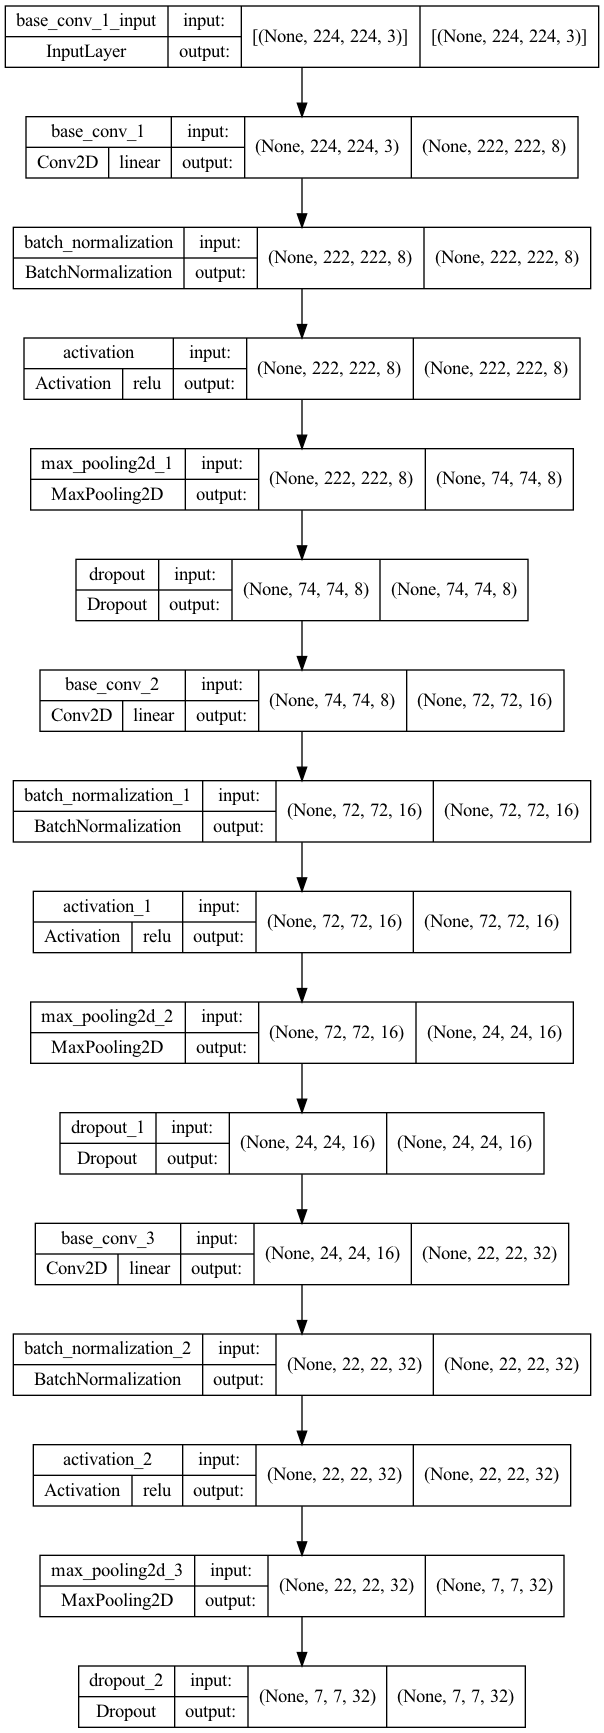

In [29]:
cnn_hypermodel = HyperCNN(
    input_shape=train_generator.image_shape)
cnn_hypermodel.build()
cnn_hypermodel.plot()

Everything looks in order, however these layers are the base layers of our model. In the next part, in order to make predictions, we will develop a *HyperTop* class which will build the *Flatten layer* and *Fully Connected layers* on top of this model.

## Hypermodel Generation: the *HyperTop class*

### *Class*

We create a *HyperTop* class which alse inheritates from the *CustomHyperModel* class. 

This *class* takes as *inputs*:
* The transfer learning *base_model*: an already trained model for *image classification*, of which the *layers* aren't *trainable* and the *top layer* not included,
* The *output shape*: the number of *classes* to predict,
* An optionnal *hyperparameter space*: a *dictionary* containing the *hyperparameters lists* to be tried.

This *class*:
* Creates the *top layers* which we will train to *predict* classes for our specific application,
* Concats the *top layers* to the *base model*,
* Compiles the final model,
* Can be passed as a *hypermodel* to the *KerasTuner tuners*.

In [30]:
class HyperTop(CustomHyperModel):

    def __init__(self, base_model, output_shape, *args, **kwargs):

        # Inits the instance with the default hyperparameters
        self.base_model = base_model
        self.params = dict(
            output_shape=output_shape,
            metrics=[
                'accuracy',
                tfa.metrics.F1Score(
                    num_classes=output_shape,
                    average='macro')])
        self.default_hyperparams = dict(
            drop_out=[0.],
            extra_layer=[True],
            layer_span=[64, 32],
            first_layers_activation=['relu'],
            output_activation=['softmax'],
            optimizer=['adam'],
            learning_rate = [1e-5])
        self.layers = 2
        self.hyperparams =copy.deepcopy(self.default_hyperparams)
        self.final_model = None
    
    def filter_lower_x(self, l, n):

        # Filter list values to form neural funnel
        return [x for x in l if x < n]

    def build(self, hp=kt.HyperParameters()):
        
        # Get params
        params = self.params
        hyperparams = self.hyperparams

        layer_spans = self.compute_combinations(
            hyperparams.get('layer_span'),
            self.filter_lower_x,
            self.layers,
            -1)
        span = hp.Choice(
            name='layer_span',
            values=range(len(layer_spans)),
            default=0)
        layer_1_units = layer_spans[span][0]
        layer_2_units = layer_spans[span][1]
        first_layers_activation = hp.Choice(
                name='first_layers_activation',
                values=hyperparams.get('first_layers_activation'),
                default='relu')
        extra_layer = hp.Boolean(
            name='extra_layer',
            default=True)
        drop_out = hp.Choice(
                name='drop_out_top',
                values=hyperparams.get('drop_out'),
                default=0)
        optimizer = hp.Choice(
                name='optimizer',
                values=hyperparams.get('optimizer'),
                default='adam')

        # Build the model if it is a KerasTuner hypermodel
        if isinstance(self.base_model, kt.HyperModel):
            base_model = self.base_model.build(hp)
            self.base_model = base_model
        base_model = self.base_model

        # Build the top layers
        model = models.Sequential(name='TopLayer')
        ## Flatten layer
        model.add(layers.Flatten(name='top_flatten'))
        ## Dense layer 1
        model.add(layers.Dense(
            name='top_dense_1',
            units=layer_1_units,
            activation=first_layers_activation))
        ## Dropout 1
        model.add(layers.Dropout(drop_out))
        if extra_layer:
            ## Dense layer 2
            model.add(layers.Dense(
                name='top_dense_2',
                units=layer_2_units,
                activation=first_layers_activation))
            ## Dropout 1
            model.add(layers.Dropout(drop_out))
        ## Output layer
        model.add(layers.Dense(
            name='output',
            units=params.get('output_shape'),
            activation=hp.Choice(
                name='layer_3_activation',
                values=hyperparams.get('output_activation'),
                default='softmax')))

        # Concat the top layers to the base model
        final_model = tf.keras.Model(
            inputs=base_model.inputs,
            outputs=model(base_model(base_model.inputs)))
        
        # Compile the final model
        final_model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=params.get('metrics'))
        
        # Sets learning rate
        K.set_value(
            final_model.optimizer.learning_rate,
            hp.Choice(
                name='learning_rate',
                values=hyperparams.get('learning_rate'),
                default=1e-5))
        if optimizer == 'sgd':
            K.set_value(
                final_model.optimizer.momentum,
                0.9)

        # Saving attributes
        self.top_layers = model
        self.final_model = final_model

        return final_model

### *Use*

* Initialize an *instance* of our *class* with its *default hyperparameters* and build the *base CNN* model:

In [31]:
cnn_final_hypermodel = HyperTop(
    layer_1_units=12,
    base_model=cnn_hypermodel,
    output_shape=N_CLASSES)
# We build the default model
cnn_final_model = cnn_final_hypermodel.build()
cnn_final_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv_1_input (InputLay  [(None, 224, 224, 3)]    0         
 er)                                                             
                                                                 
 CNN (Sequential)            (None, 7, 7, 32)          6200      
                                                                 
 TopLayer (Sequential)       (None, 3)                 102595    
                                                                 
Total params: 108,795
Trainable params: 108,683
Non-trainable params: 112
_________________________________________________________________


* Plot the *models structure*:

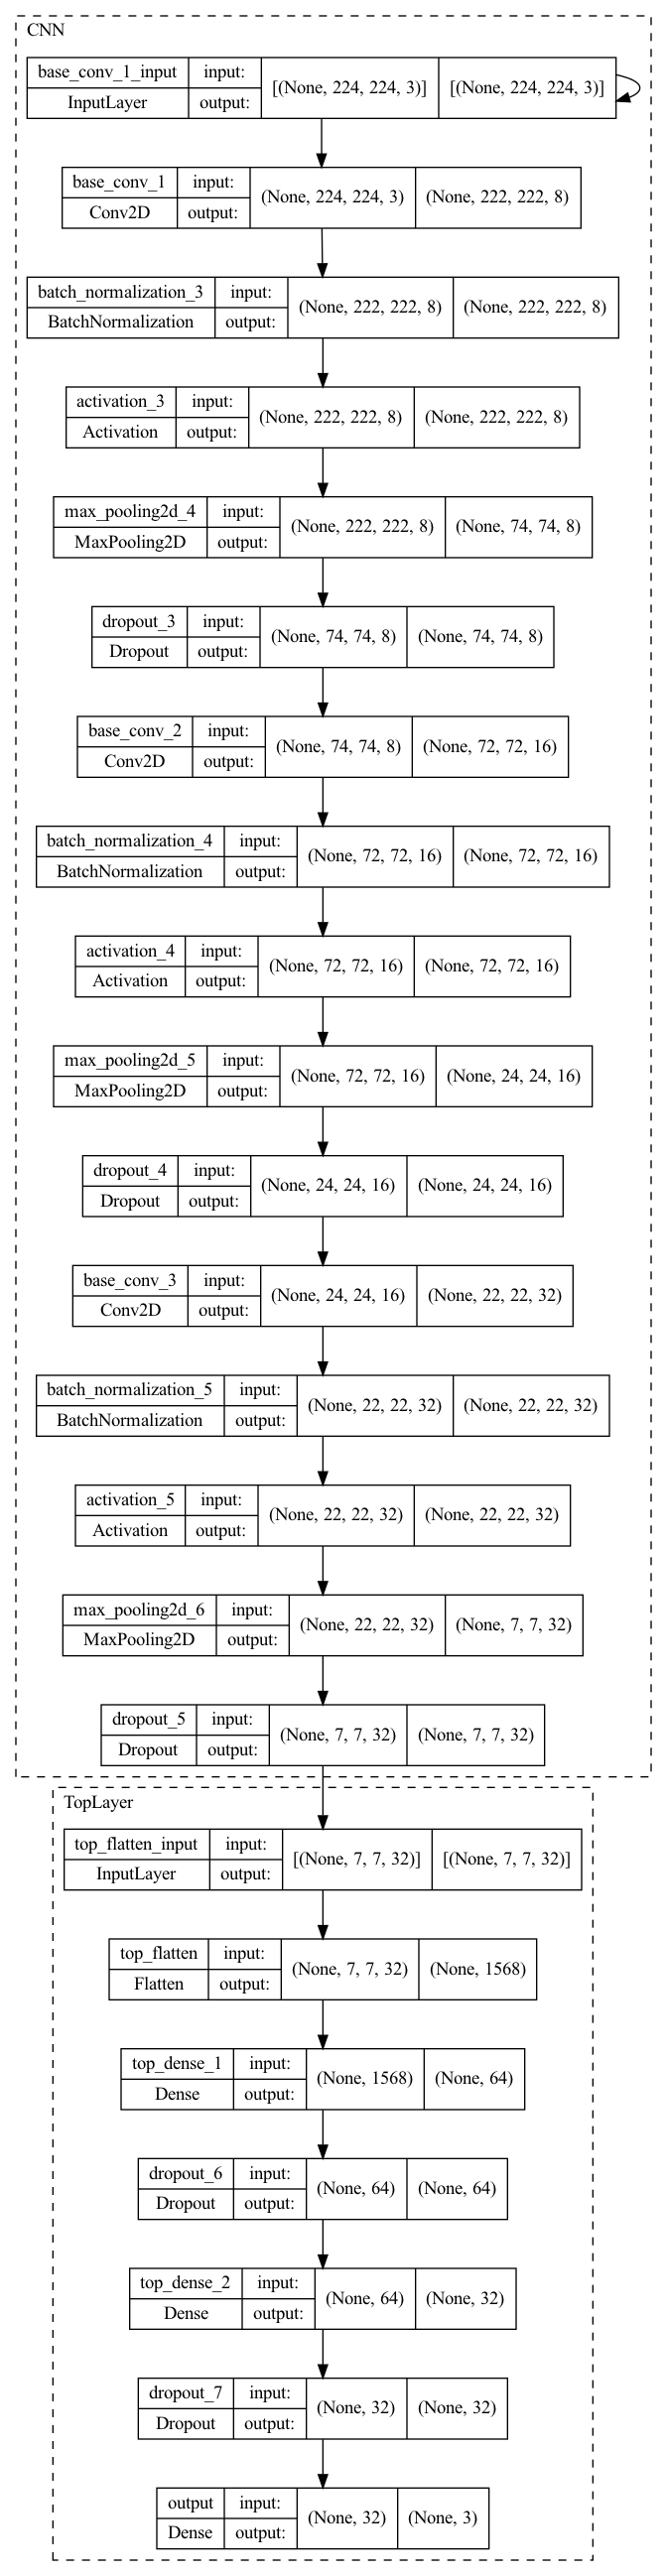

In [32]:
cnn_final_hypermodel.plot()

* Print the *default hyperparameters* of the *hypermodel*:

In [33]:
cnn_final_hypermodel.default_hyperparams

{'drop_out': [0.0],
 'extra_layer': [True],
 'layer_span': [64, 32],
 'first_layers_activation': ['relu'],
 'output_activation': ['softmax'],
 'optimizer': ['adam'],
 'learning_rate': [1e-05]}

* Update the *hyperparameters space* of the *hypermodel* by passing arguments to the *class*:

In [34]:
cnn_final_hypermodel.update_hyperparams(layer_span=128)
cnn_final_hypermodel.hyperparams

{'drop_out': [0.0],
 'extra_layer': [True],
 'layer_span': [64, 32, 128],
 'first_layers_activation': ['relu'],
 'output_activation': ['softmax'],
 'optimizer': ['adam'],
 'learning_rate': [1e-05]}

* Initialize the *tuner* with our *final hypermodel*:

In [35]:
# We create a KerasTuner RandomSearch instance
tuner = kt.RandomSearch(
    hypermodel=cnn_final_hypermodel,
    objective='val_loss',
    max_trials=5)

* Launch *training*:

In [36]:
# # Forces the use of the GPU for training
# with tf.device('/device:GPU:0'):
#     # We apply the search method of the KerasTuner instance
#     tuner.search(
#         train_generator,
#         validation_data=val_generator,
#         steps_per_epoch=steps_per_epoch,
#         validation_steps=validation_steps,
#         verbose=1,
#         epochs=1)

## Evaluation: the *PerformanceReport class*

### *Class*

In order to track our experiments results, we create a *class* which will ingest performance summaries of *KerasTuner* and output a performance report in the form of a *Pandas DataFrame*:

We will track the following metrics:
* The score (the *Categorical Crossestropy* loss),
* The *Categorical Accuracy*,
* The *F1 score*,

On both the training and validation sets.

We will also save the best *hyperparameters dictionnaries* as well as the *best models* of each run.

In [37]:
class PerformanceReport():

    def __init__(self):

        # Initiliaze the report DataFrame
        self.report = pd.DataFrame(
            columns=[
                'algorithm',
                'search',
                'n_classes',
                'train_score',
                'train_accuracy',
                'train_f1_score',
                'val_score',
                'val_accuracy',
                'val_f1_score',
                'hyperparameters',
                'tuner',
                'model']
                ).set_index(['algorithm','search'])

    def update(self, model_name, tuner_name, tuner, results, n_classes):
        
        # Get values from the Oracle
        best_trial = tuner.oracle.get_best_trials(1)[0]
        best_epoch = np.argmax(np.array(best_trial.metrics.get_history('val_loss')))
        val_score = best_trial.metrics.get_history('val_loss')[best_epoch].value[0]
        params = best_trial.hyperparameters.values
        model = tuner.get_best_models(1)[0]

        # Set values in the report dataframe
        self.report.loc[(model_name, tuner_name),:] = [
            n_classes,
            results.get('train_loss'),
            results.get('train_accuracy'),
            results.get('train_f1_score'),
            val_score,            
            results.get('val_accuracy'),
            results.get('val_f1_score'),
            params,
            tuner,
            model]

    def get(self):
        
        # Get the report dataframe
        return self.report

### *Use*

* Create a *PerformanceReport instance* to which the performances will be added:

In [38]:
report = PerformanceReport()
report.get()

Empty DataFrame
Columns: [n_classes, train_score, train_accuracy, train_f1_score, val_score, val_accuracy, val_f1_score, hyperparameters, tuner, model]
Index: []

## Hyperparameters Search: the *HyperSearch class*

### *Class*

We develop a *HyperSearch class* in order to wrap the *KerasTuner tuners*, facilitate the generation of *logs* to be read by *Tensorboard* & save the results to the *PerformanceReport* instance we initialized during our test.

In order to improve our optimization and follow our experiments, we are implementing *callbacks*:
* *Tensorboard*: the *TensorFlow experiments visualization library*,
* *Early Stopping*: to stop the model training if the score is not improving.

val data n'est pas le tableau filtrer -> récupérer les steps du tableau filtré

In [39]:
class HyperSearch():
    
    def __init__(self, train_data, val_data, train_datagen, val_datagen, generator_settings, report=None):
        
        # Store settings
        self.generator_settings = generator_settings
        self.batch_size = generator_settings.get('batch_size')
        # Store the training and validation datasets for creating generators
        self.train_data = train_data
        self.val_data = val_data
        # Store the datagens for creating generators
        self.train_datagen = train_datagen
        self.val_datagen = val_datagen
        # We will update our PerformanceReport
        if report == None: self.report = PerformanceReport()
        if report != None: self.report = report

    def get_n_classes(self, n_classes):

        # Generate subset with n classes
        return get_n_classes(
            self.train_data,
            self.val_data,
            n_classes)

    def gen_generators(self, n_classes):    
        
        # Get filtered n classes datasets
        train_df, val_df = self.get_n_classes(n_classes)
        # Prepares format for datagens
        train_df['labels'] = train_df['labels'].astype(str)
        val_df['labels'] = val_df['labels'].astype(str)
        # Initialize generators
        print('Validation:\n')
        train_generator = self.train_datagen.flow_from_dataframe(
            dataframe=train_df,
            **self.generator_settings)
        print('\nTraining:\n')
        val_generator = self.val_datagen.flow_from_dataframe(
            dataframe=val_df,
            **self.generator_settings)
        # Set steps_per_epochs & validation_steps for fitting
        self.steps_per_epoch = train_generator.samples // train_generator.batch_size
        self.validation_steps = val_generator.samples // val_generator.batch_size
        # Transform the generators to TensorFlow Datasets
        target_size = self.generator_settings.get('target_size')
        output_types = (tf.float32, tf.float32)
        output_shapes = (
            [None, target_size[0], target_size[1], 3],
            [None, n_classes])
        self.train_generator = tf.data.Dataset.from_generator(
            lambda: train_generator,
            output_types=output_types,
            output_shapes=output_shapes).repeat()
        # We use the repeat method to iterate other the Datasets
        self.val_generator = tf.data.Dataset.from_generator(
            lambda: val_generator,
            output_types=output_types,
            output_shapes=output_shapes).repeat()
    
    def gen_callbacks(self, log_path):

        # Set up Tensorboard
        tensorboard = tf.keras.callbacks.TensorBoard(f'{log_path}/tensorboard')
        
        # Set up the early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            mode='min',
            patience=10,
            restore_best_weights=True)
        
        # Reduce learning rate on plateau
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            mode='min',
            min_delta=0.00001,
            factor=0.25,
            patience=5,
            min_lr=4e-05,
            verbose=1)

        # Store callbacks
        self.callbacks = [tensorboard, early_stopping, reduce_lr]

    def experiment_warmup(self, model_name, hypermodel):

        # Generate TensorBoard log_path and generate callbacks
        self.log_path = model_name + '_log'
        self.gen_callbacks(self.log_path)
        # Save output_shape
        self.n_classes = hypermodel.params.get('output_shape')
        # Gen generators
        self.gen_generators(self.n_classes)

    def search(self, tuner, hyparameters):

        # Fit the tuner using the hyperparameters
        with tf.device('/device:GPU:0'):
            tuner.search(
                self.train_generator,
                validation_data=self.val_generator,
                steps_per_epoch=self.steps_per_epoch,
                validation_steps=self.validation_steps,
                callbacks=self.callbacks,
                verbose=1,
                **hyparameters)
        
        return tuner

    def random_search(self, model_name, hypermodel, max_trials, hyperparams=dict()):

        # Prepare experiment
        self.experiment_warmup(model_name, hypermodel)

        # Prepare the tuner
        tuner = kt.RandomSearch(
            hypermodel=hypermodel,
            objective='val_loss',
            overwrite=True,
            project_name='kerastuner',
            directory=self.log_path,
            max_trials=max_trials,
            seed=42)
        tuner_name = 'random_search'

        # Search using the tuner
        tuner = self.search(tuner, hyperparams)

        # Get best epoch scores from history
        results = self.get_best_epoch_metrics(tuner)

        # Update report
        self.report.update(
            model_name,
            tuner_name,
            tuner,
            results,
            hypermodel.params.get('output_shape'))

        return tuner

    def hyperband(self, model_name, hypermodel, max_epochs, factor, hyperband_iterations, hyperparams=dict()):

        # Prepare experiment
        self.experiment_warmup(model_name, hypermodel)

        # Prepare the tuner
        tuner = kt.Hyperband(
            hypermodel=hypermodel,
            objective='val_loss',
            overwrite=True,
            directory=self.log_path,
            max_epochs=max_epochs,
            factor=factor,
            hyperband_iterations=hyperband_iterations,
            seed=42)
        tuner_name = 'hyperband'

        # Search using the tuner
        tuner = self.search(tuner, hyperparams)

        # Get best epoch scores from history
        results = self.get_best_epoch_metrics(tuner)

        # Update report
        self.report.update(
            model_name,
            tuner_name,
            tuner,
            results,
            hypermodel.params.get('output_shape'))

        return tuner

    def get_best_epoch_metrics(self, tuner):

        # Read the best history using Tensorflows summary_iterator

        # Selects the objectives dataset
        objective = tuner.oracle.objective.name
        sets = ['validation', 'train']
        if objective.startswith('val_'): dataset = sets[0]
        else: dataset = sets[1]

        # Get best epoch
        epoch = 0
        best_epoch = 0
        best_score = 9999
        # Find the best epoch
        iterator = self.gen_iterator(tuner, dataset)
        for e in iterator:
            for v in e.summary.value:
                if v.tag == 'epoch_loss':
                    value = tf.make_ndarray(v.tensor).tolist()
                    if value < best_score:
                        best_score = value
                        best_epoch = epoch
                    else: continue
                    epoch += 1

        # Initialize results
        results = dict()
        # Reset the iterator
        iterator = self.gen_iterator(tuner, dataset)
        # Metrics to pick
        metrics = ['accuracy', 'f1_score']
        # Iterate over best epoch to obtain best metrics
        results = self.get_epoch_metrics(
            results,
            iterator,
            best_epoch,
            dataset,
            metrics)
        # Do the same over secondary objective
        sets.remove(dataset)
        dataset_bis = sets[0]
        iterator = self.gen_iterator(tuner, dataset_bis)
        results = self.get_epoch_metrics(
            results,
            iterator,
            dataset_bis,
            best_epoch,
            metrics=metrics+['loss'])

        return results

    def gen_iterator(self, tuner, dataset):

        # Get the best trial id
        best_trial = tuner.oracle.get_best_trials()[0].trial_id
        # Computes event file path
        trial_path = f'./{self.log_path}/tensorboard/{best_trial}/execution0/{dataset}'
        events_file_path = f'{trial_path}/{os.listdir(trial_path)[0]}'
        # Generate the summary_iterator
        iterator = summary_iterator(events_file_path)

        return iterator
    
    def get_epoch_metrics(self, results, iterator, best_epoch, dataset, metrics):

        scored = 0
        epoch = 0
        if dataset == 'validation': prefix = 'val_'
        if dataset == 'train': prefix = 'train_'
        for e in iterator:
            for v in e.summary.value:
                for metric in metrics:
                    if dataset=='train':
                        print(v.tag)
                    if v.tag == f'epoch_{metric}':
                        if scored == len(metrics):
                            break
                        if epoch != best_epoch:
                            epoch += 1
                            continue
                        if epoch == best_epoch:
                            results[prefix + metric] = tf.make_ndarray(v.tensor).tolist()
                            scored += 1
        
        return results

### *Use*

* The use of this class is explicited in the next part of this *notebook*.

# Training

* Create a blank *PerformanceReport*:

In [40]:
# Initialze an instance of PerformanceReport()
report = PerformanceReport()
report.get()

Empty DataFrame
Columns: [n_classes, train_score, train_accuracy, train_f1_score, val_score, val_accuracy, val_f1_score, hyperparameters, tuner, model]
Index: []

## CNN

* Initialize a *HyperCNN instance* to generate the *base model* and a *HyperTop* instance to *concatenate* the *top layers* to its *base layers*:

In [41]:
cnn_hypermodel = HyperCNN(
    input_shape=train_generator.image_shape,
    kernel_dim=[6, 12, 24],
    filters_span=[128, 256],
    drop_out=[0.2, 0.4])
hypermodel = HyperTop(
    base_model=cnn_hypermodel,
    output_shape=N_CLASSES)

* Show the *cnn_hypermodel default hyperparameters*:

In [42]:
cnn_hypermodel.default_hyperparams

{'drop_out': [0.0], 'filters_span': [8, 16, 32], 'kernel_dim': [3]}

* Show the *cnn_hypermodel hyperparameters*:

In [43]:
cnn_hypermodel.hyperparams

{'drop_out': [0.0, 0.4, 0.2],
 'filters_span': [32, 128, 256, 8, 16],
 'kernel_dim': [24, 3, 12, 6]}

* Show the *final hypermodel default hyperparameters*:

In [44]:
hypermodel.default_hyperparams

{'drop_out': [0.0],
 'extra_layer': [True],
 'layer_span': [64, 32],
 'first_layers_activation': ['relu'],
 'output_activation': ['softmax'],
 'optimizer': ['adam'],
 'learning_rate': [1e-05]}

* Create a *dictionary* for the *hyperparameters search space*:

In [45]:
hypertop_hyperparams = dict(
    drop_out=[0.4, 0.6],
    layer_span=[128, 256, 512],
    first_layers_activation='tanh',
    output_activation='sigmoid',
    optimizer='sgd',
    learning_rate=1e-3)

* Add extra *hyperparameter Choices* to the *final hypermodel*:

In [46]:
hypermodel.update_hyperparams(**hypertop_hyperparams)
hypermodel.hyperparams

{'drop_out': [0.0, 0.4, 0.6],
 'extra_layer': [True],
 'layer_span': [64, 256, 32, 128, 512],
 'first_layers_activation': ['relu', 'tanh'],
 'output_activation': ['sigmoid', 'softmax'],
 'optimizer': ['sgd', 'adam'],
 'learning_rate': [1e-05, 0.001]}

* Initiliaze and *HyperSearch instance* with the *training*, the *test data* & the *report*:

In [47]:
# Initialize an instance of HyperSearch()
search = HyperSearch(
    train_data=train_df_init,
    val_data=val_df_init,
    train_datagen=train_datagen,
    val_datagen=val_datagen,
    generator_settings=generator_settings,
    report=report)

* Apply a *random search* by passing the *model name*, *hypermodel* and *optional fit parameters*:

In [48]:
# The random_search method launches an instance of kt.RandomSearch()
tuner = search.random_search(
    model_name='cnn',
    hypermodel=hypermodel,
    max_trials=2,
    hyperparams=dict(
        epochs=2))

Trial 2 Complete [00h 00m 05s]
val_loss: 1.1047046184539795

Best val_loss So Far: 1.0574785470962524
Total elapsed time: 00h 00m 13s
INFO:tensorflow:Oracle triggered exit
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


* Use the *KerasTuner tuner* and list the best runs:

In [49]:
tuner.results_summary(1)

Results summary
Results in cnn_log/kerastuner
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
layer_span: 0
first_layers_activation: relu
extra_layer: False
drop_out_top: 0.4
optimizer: sgd
filter_span: 1
kernel_dim: 12
drop_out_cnn: 0.0
layer_3_activation: softmax
learning_rate: 1e-05
Score: 1.0574785470962524


* Show the *Tensorboard panel*:

In [50]:
%tensorboard --logdir cnn_log

* Print the *report*:

In [51]:
report.get()

n_classes train_score train_accuracy train_f1_score  \
algorithm search                                                              
cnn       random_search         3        None           None           None   

                        val_score val_accuracy val_f1_score  \
algorithm search                                              
cnn       random_search  1.057479     0.551111     0.228522   

                                                           hyperparameters  \
algorithm search                                                             
cnn       random_search  {'layer_span': 0, 'first_layers_activation': '...   

                                                                     tuner  \
algorithm search                                                             
cnn       random_search  <keras_tuner.tuners.randomsearch.RandomSearch ...   

                                                                     model  
algorithm search                                                            
cnn       random_search  <keras.engine.functional.Functional object at ...

In [52]:
stop

NameError: name 'stop' is not defined

## VGG16 *(Transfer Learning)*

We are importing the VGG16 but we do not include its top layer. We will use the VGG16 as a base model, rendering it non trainable:

In [ ]:
# Load the VGG16 model
base_vgg = VGG16(
    weights="imagenet",
    include_top=False, 
    input_shape=train_generator.image_shape)
base_vgg.trainable = False
base_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

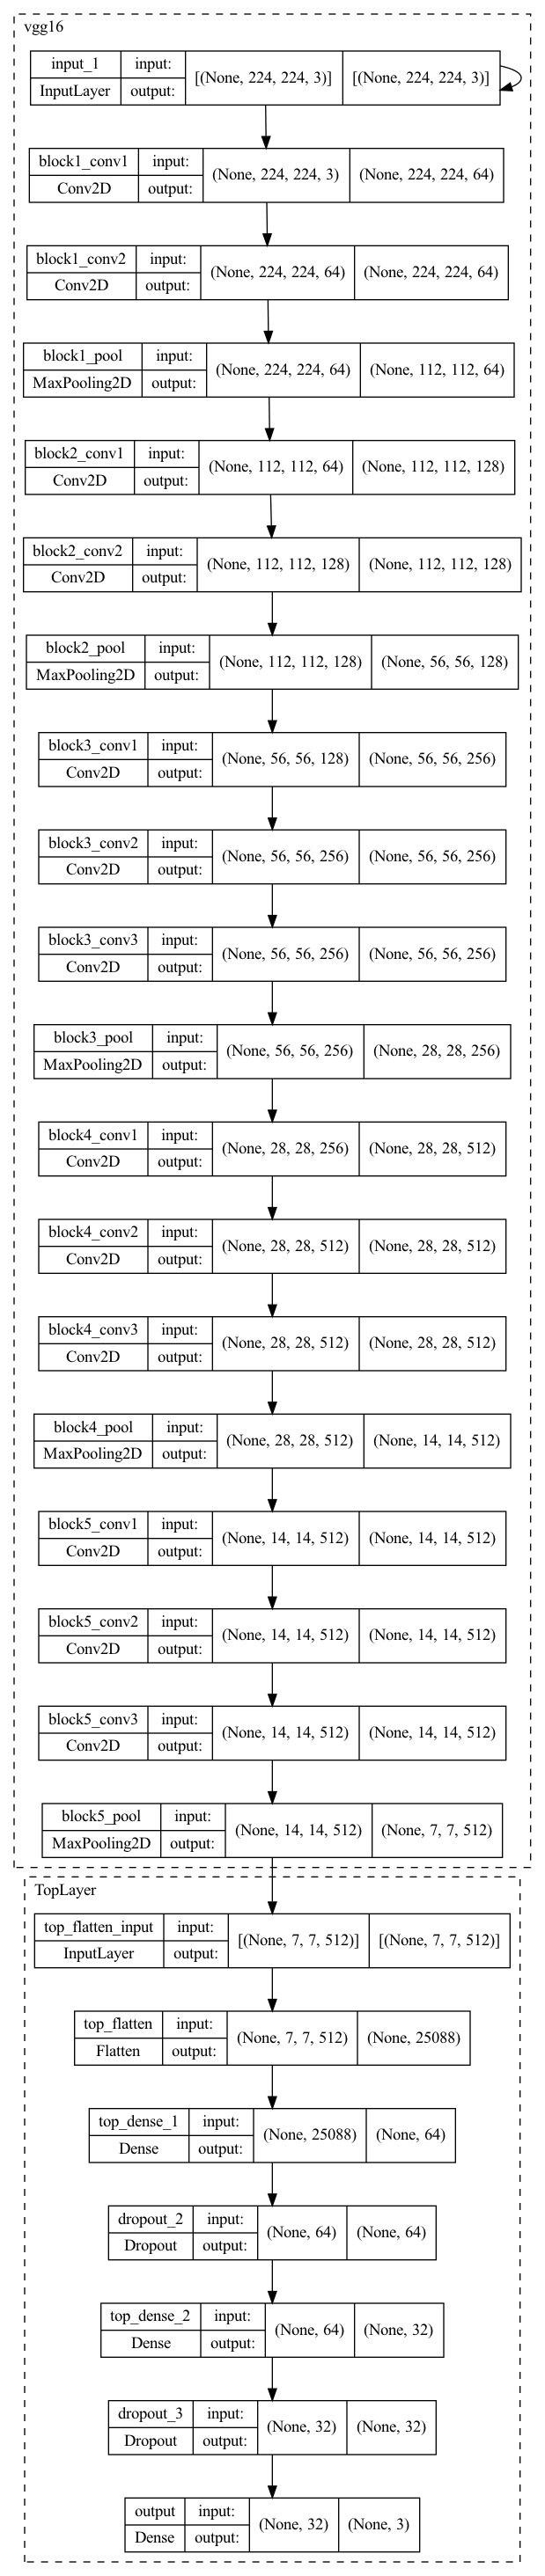

In [ ]:
hypermodel = HyperTop(
    base_model=base_vgg,
    output_shape=N_CLASSES,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    **hypertop_hyperparams)
hypermodel.build()
hypermodel.plot()

In [ ]:
# The random_search method launches an instance of kt.RandomSearch()
tuner = search.random_search(
    model_name='vgg',
    hypermodel=hypermodel,
    max_trials=25,
    hyperparams=dict(
        epochs=30))

/var/folders/1h/861cc3q97gb3f6r361ydtk9m0000gn/T/ipykernel_6006/1363725089.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['labels'] = train_df['labels'].astype(str)
/var/folders/1h/861cc3q97gb3f6r361ydtk9m0000gn/T/ipykernel_6006/1363725089.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['labels'] = val_df['labels'].astype(str)


Validation:

Found 300 validated image filenames belonging to 3 classes.

Training:

Found 289 validated image filenames belonging to 3 classes.

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
layer_span        |0                 |?                 
first_layers_ac...|relu              |?                 
extra_layer       |False             |?                 
drop_out_top      |0                 |?                 
optimizer         |adam              |?                 
layer_3_activation|softmax           |?                 
learning_rate     |1e-05             |?                 

Epoch 1/30


2022-05-07 18:10:55.673320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - ETA: 0s - loss: 1.2310 - accuracy: 0.2812 - f1_score: 0.2688

2022-05-07 18:11:02.083051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 12s 3s/step - loss: 1.2310 - accuracy: 0.2812 - f1_score: 0.2688 - val_loss: 1.1568 - val_accuracy: 0.3086 - val_f1_score: 0.3058 - lr: 1.0000e-05
Epoch 2/30
4/4 [==============================] - 10s 3s/step - loss: 1.1420 - accuracy: 0.3517 - f1_score: 0.3517 - val_loss: 1.1611 - val_accuracy: 0.3556 - val_f1_score: 0.3554 - lr: 1.0000e-05
Epoch 3/30
4/4 [==============================] - 11s 3s/step - loss: 1.1264 - accuracy: 0.3051 - f1_score: 0.2959 - val_loss: 1.1526 - val_accuracy: 0.3244 - val_f1_score: 0.3314 - lr: 1.0000e-05
Epoch 4/30
4/4 [==============================] - 11s 3s/step - loss: 1.0489 - accuracy: 0.4322 - f1_score: 0.4245 - val_loss: 1.0399 - val_accuracy: 0.4489 - val_f1_score: 0.4506 - lr: 1.0000e-05
Epoch 5/30
4/4 [==============================] - 11s 3s/step - loss: 1.0480 - accuracy: 0.4195 - f1_score: 0.4198 - val_loss: 1.0454 - val_accuracy: 0.4400 - val_f1_score: 0.4447 - lr: 1.0000e-05
Epoch 6/30
4/4 [==========

KeyboardInterrupt: 

***Please note that Tensorboad runs on a web server and will not be saved as an output of the notebook. If running this notebook, the Tensorboard app might not appear at the first execution of the following cell. In that case, execute the following cell a second time.***

In [ ]:
%tensorboard --logdir vgg_log

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
report.get()

n_classes val_score val_accuracy val_f1_score  \
algorithm search                                                        
cnn       random_search         3   0.81499     0.475556     0.361177   
vgg       random_search         3   0.67061     0.609375     0.561711   

                                                           hyperparameters  \
algorithm search                                                             
cnn       random_search  {'layer_span': 2, 'first_layers_activation': '...   
vgg       random_search  {'layer_span': 0, 'first_layers_activation': '...   

                                                                     tuner  \
algorithm search                                                             
cnn       random_search  <keras_tuner.tuners.randomsearch.RandomSearch ...   
vgg       random_search  <keras_tuner.tuners.randomsearch.RandomSearch ...   

                                                                     model  
algorithm search                                                            
cnn       random_search  <keras.engine.functional.Functional object at ...  
vgg       random_search  <keras.engine.functional.Functional object at ...

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

## InceptionV3 (Transfer Learning)

In [ ]:
# Load the Inception model
base_inception = InceptionV3(
    weights="imagenet",
    include_top=False, 
    input_shape=train_generator.image_shape)
base_inception.trainable = False

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

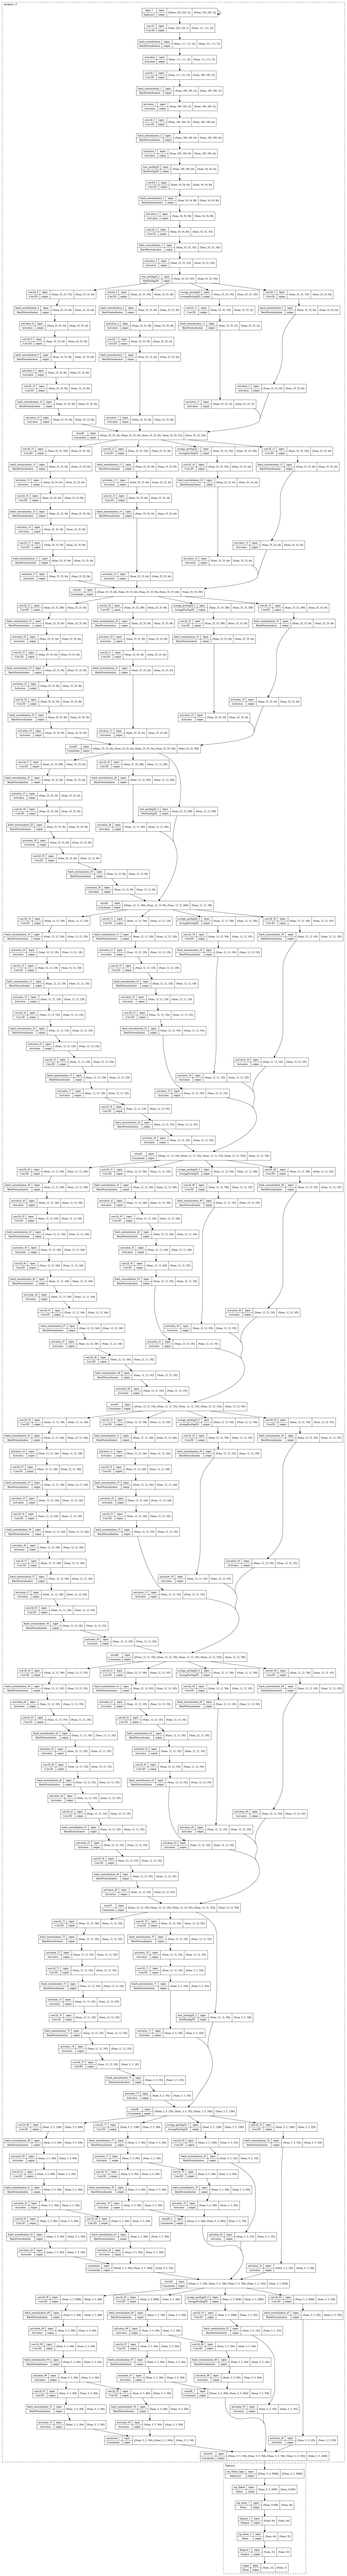

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
hypermodel = HyperTop(
    base_model=base_inception,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    output_shape=N_CLASSES,
    **hypertop_hyperparams)
hypermodel.build()
hypermodel.plot()

In [ ]:
# The random_search method launches an instance of kt.RandomSearch()
tuner = search.random_search(
    model_name='inception',
    hypermodel=hypermodel,
    max_trials=25,
    hyperparams=dict(
        epochs=10))

Trial 2 Complete [00h 01m 58s]
val_loss: 0.04350836202502251

Best val_loss So Far: 0.04088100045919418
Total elapsed time: 00h 03m 40s
INFO:tensorflow:Oracle triggered exit


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

* As you can see, the tuning of this model for predicting has been stopped by the *Oracle* prematurely. This is because the model at this point has already reached a near than perfect loss.

In [ ]:
%tensorboard --logdir inception_log

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

tanh, 256, 64, softmax, 1e-5

In [ ]:
tuner.results_summary(3)

Results summary
Results in inception_log/kerastuner
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
layer_span: 0
first_layers_activation: relu
extra_layer: False
drop_out_top: 0.0
optimizer: adam
layer_3_activation: softmax
learning_rate: 1e-05
Score: 0.04088100045919418
Trial summary
Hyperparameters:
layer_span: 0
first_layers_activation: relu
extra_layer: True
drop_out_top: 0.0
optimizer: adam
layer_3_activation: softmax
learning_rate: 1e-05
Score: 0.04350836202502251


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
report.get()

n_classes val_score val_accuracy val_f1_score  \
algorithm search                                                        
cnn       random_search         3   0.81499     0.475556     0.361177   
vgg       random_search         3   0.67061     0.609375     0.561711   
inception random_search         3  0.040881     0.982222     0.977671   

                                                           hyperparameters  \
algorithm search                                                             
cnn       random_search  {'layer_span': 2, 'first_layers_activation': '...   
vgg       random_search  {'layer_span': 0, 'first_layers_activation': '...   
inception random_search  {'layer_span': 0, 'first_layers_activation': '...   

                                                                     tuner  \
algorithm search                                                             
cnn       random_search  <keras_tuner.tuners.randomsearch.RandomSearch ...   
vgg       random_search  <keras_tuner.tuners.randomsearch.RandomSearch ...   
inception random_search  <keras_tuner.tuners.randomsearch.RandomSearch ...   

                                                                     model  
algorithm search                                                            
cnn       random_search  <keras.engine.functional.Functional object at ...  
vgg       random_search  <keras.engine.functional.Functional object at ...  
inception random_search  <keras.engine.functional.Functional object at ...

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
report.get()['hyperparameters']['inception']['random_search']

{'layer_span': 0,
 'first_layers_activation': 'relu',
 'extra_layer': False,
 'drop_out_top': 0.0,
 'optimizer': 'adam',
 'layer_3_activation': 'softmax',
 'learning_rate': 1e-05}

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
tf.keras.models.save_model(tuner.get_best_models()[0], 'model.h5')

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

### Hyperband

In [ ]:
# hypermodel.reset_hyperparams()
# hypermodel.hyperparams

{'drop_out': [0.0],
 'extra_layer': [True],
 'layer_span': [64, 32],
 'first_layers_activation': ['relu'],
 'output_activation': ['softmax'],
 'optimizer': ['adam'],
 'learning_rate': [1e-05]}

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# hypermodel.update_hyperparams(
#     drop_out = [0.3, 0.6],
#     layer_1_units=[64, 32],
#     layer_2_units=[64, 128],
#     first_layers_activation='tanh',
#     output_activation='sigmoid',
#     optimizer='sgd')
# hypermodel.hyperparams

KeyError: 'layer_1_units'

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# tuner = search.hyperband(
#     hypermodel=hypermodel,
#     model_name='inception',
#     hyperband_iterations=10,
#     max_epochs=10,
#     factor=3,
#     hyperparams=dict(
#         epochs=3))

Validation:

Found 300 validated image filenames belonging to 3 classes.

Training:

Found 289 validated image filenames belonging to 3 classes.


/var/folders/1h/861cc3q97gb3f6r361ydtk9m0000gn/T/ipykernel_4365/918256987.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['labels'] = train_df['labels'].astype(str)
/var/folders/1h/861cc3q97gb3f6r361ydtk9m0000gn/T/ipykernel_4365/918256987.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['labels'] = val_df['labels'].astype(str)


ValueError: `values` must be provided.

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
report.get()

train_score val_score train_accuracy val_accuracy  \
algorithm search                                                            
cnn       random_search    0.869977  0.890738       0.463768        0.375   
vgg       random_search    0.345105  0.422358       0.478261     0.694444   
inception random_search     0.09034       0.0         0.8125     0.958333   
          hyperband        0.116099  0.005995       0.844203     0.982639   

                        train_f1_score val_f1_score  \
algorithm search                                      
cnn       random_search       0.456639     0.230303   
vgg       random_search       0.453512     0.633455   
inception random_search       0.898146     0.951502   
          hyperband           0.917456     0.976441   

                                                           hyperparameters  \
algorithm search                                                             
cnn       random_search  {'first_layers_activation': 'relu', 'kernel_di...   
vgg       random_search  {'first_layers_activation': 'relu', 'layer_1_u...   
inception random_search  {'first_layers_activation': 'relu', 'layer_1_u...   
          hyperband      {'first_layers_activation': 'relu', 'layer_1_u...   

                                                                     tuner  \
algorithm search                                                             
cnn       random_search  <keras_tuner.tuners.randomsearch.RandomSearch ...   
vgg       random_search  <keras_tuner.tuners.randomsearch.RandomSearch ...   
inception random_search  <keras_tuner.tuners.randomsearch.RandomSearch ...   
          hyperband      <keras_tuner.tuners.hyperband.Hyperband object...   

                                                                     model  
algorithm search                                                            
cnn       random_search  <keras.engine.functional.Functional object at ...  
vgg       random_search  <keras.engine.functional.Functional object at ...  
inception random_search  <keras.engine.functional.Functional object at ...  
          hyperband      <keras.engine.functional.Functional object at ...

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

## InceptionV3 (120 classes)

For our demo app *(POC)*, we will train a model on the whole 120 classes. Being limited in computing ressources, we will only apply a very sparse *random search*.

In [ ]:
N_CLASSES = 120

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

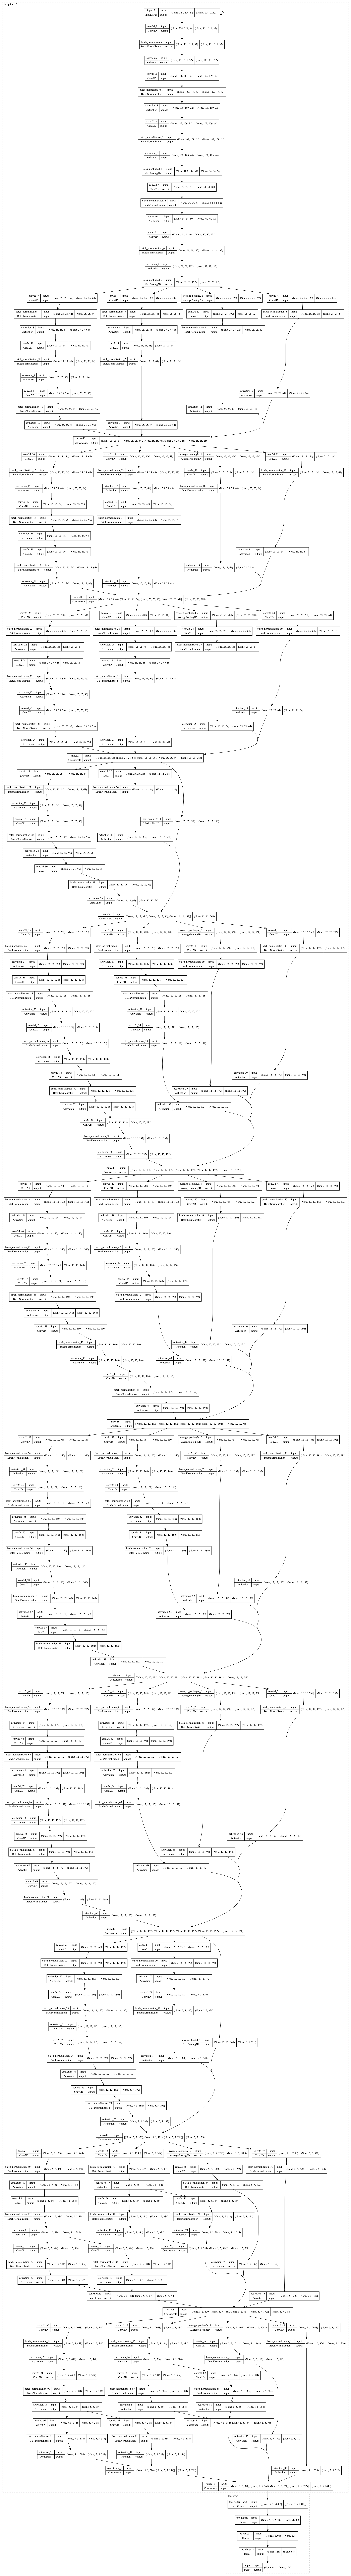

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
hypermodel = HyperTop(
    base_model=base_inception,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    output_shape=N_CLASSES)
hypermodel.build()

In [ ]:
hypermodel.update_hyperparams(
    layer_1_units=[128, 256],
    layer_2_units=[256, 512],
    first_layers_activation='tanh',
    output_activation='sigmoid',
    optimizer='sgd',
    learning_rate=[1e-5, 1e-7])
hypermodel.hyperparams

{'layer_1_units': [128, 256],
 'layer_2_units': [64, 256, 512],
 'first_layers_activation': ['tanh', 'relu'],
 'output_activation': ['sigmoid', 'softmax'],
 'optimizer': ['adam', 'sgd'],
 'learning_rate': [1e-05, 1e-07, 0.001],
 'loss': ['categorical_crossentropy']}

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
# The random_search method launches an instance of kt.RandomSearch()
tuner = search.random_search(
    model_name='inception',
    hypermodel=hypermodel,
    max_trials=10,
    hyperparams=dict(
        epochs=10))

Trial 10 Complete [00h 59m 40s]
val_loss: 4.628715515136719

Best val_loss So Far: 0.8382729887962341
Total elapsed time: 12h 07m 27s
INFO:tensorflow:Oracle triggered exit


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
%tensorboard --logdir inception_log

Reusing TensorBoard on port 6006 (pid 13447), started 0:00:03 ago. (Use '!kill 13447' to kill it.)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

tanh, 256, 64, softmax, 1e-5

In [ ]:
tuner.results_summary(1)

Results summary
Results in inception_log/untitled_project
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
first_layers_activation: tanh
layer_1_units: 256
layer_2_units: 256
layer_3_activation: sigmoid
optimizer: adam
loss: categorical_crossentropy
learning_rate: 1e-05
Score: 0.8382729887962341


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
tuner.get_best_hyperparameters(1)

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
report.get()

n_classes train_score val_score train_accuracy  \
algorithm search                                                         
inception random_search       120    1.133685  0.838273         0.3995   

                        val_accuracy train_f1_score val_f1_score  \
algorithm search                                                   
inception random_search     0.715618       0.261611     0.699988   

                                                           hyperparameters  \
algorithm search                                                             
inception random_search  {'first_layers_activation': 'tanh', 'layer_1_u...   

                                                                     tuner  \
algorithm search                                                             
inception random_search  <keras_tuner.tuners.randomsearch.RandomSearch ...   

                                                                     model  
algorithm search                                                            
inception random_search  <keras.engine.functional.Functional object at ...

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
report.get()['hyperparameters']['inception']['random_search']

{'first_layers_activation': 'tanh',
 'layer_1_units': 256,
 'layer_2_units': 256,
 'layer_3_activation': 'sigmoid',
 'optimizer': 'adam',
 'loss': 'categorical_crossentropy',
 'learning_rate': 1e-05}

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
tf.keras.models.save_model(tuner.get_best_models()[0], 'model.h5')

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

### Hyperband

In [ ]:
hypermodel.reset_hyperparams()
hypermodel.hyperparams

{'layer_1_units': [128],
 'layer_2_units': [64],
 'first_layers_activation': ['relu'],
 'output_activation': ['softmax'],
 'optimizer': ['adam'],
 'loss': ['categorical_crossentropy']}

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
hypermodel.update_hyperparams(
    layer_1_units=[64, 32],
    layer_2_units=[64, 128],
    first_layers_activation='tanh',
    output_activation='sigmoid',
    optimizer='sgd')
hypermodel.hyperparams

{'layer_1_units': [128, 32, 64],
 'layer_2_units': [64, 128],
 'first_layers_activation': ['tanh', 'relu'],
 'output_activation': ['softmax', 'sigmoid'],
 'optimizer': ['sgd', 'adam'],
 'loss': ['categorical_crossentropy']}

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
tuner = search.hyperband(
    hypermodel=hypermodel,
    model_name='inception',
    hyperband_iterations=10,
    max_epochs=10,
    factor=3,
    hyperparams=dict(
        epochs=3))

Trial 62 Complete [00h 00m 36s]
val_loss: 0.054326627403497696

Best val_loss So Far: 0.005994821898639202
Total elapsed time: 00h 41m 06s
INFO:tensorflow:Oracle triggered exit


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
report.get()

train_score val_score train_accuracy val_accuracy  \
algorithm search                                                            
cnn       random_search    0.869977  0.890738       0.463768        0.375   
vgg       random_search    0.345105  0.422358       0.478261     0.694444   
inception random_search     0.09034       0.0         0.8125     0.958333   
          hyperband        0.116099  0.005995       0.844203     0.982639   

                        train_f1_score val_f1_score  \
algorithm search                                      
cnn       random_search       0.456639     0.230303   
vgg       random_search       0.453512     0.633455   
inception random_search       0.898146     0.951502   
          hyperband           0.917456     0.976441   

                                                           hyperparameters  \
algorithm search                                                             
cnn       random_search  {'first_layers_activation': 'relu', 'kernel_di...   
vgg       random_search  {'first_layers_activation': 'relu', 'layer_1_u...   
inception random_search  {'first_layers_activation': 'relu', 'layer_1_u...   
          hyperband      {'first_layers_activation': 'relu', 'layer_1_u...   

                                                                     tuner  \
algorithm search                                                             
cnn       random_search  <keras_tuner.tuners.randomsearch.RandomSearch ...   
vgg       random_search  <keras_tuner.tuners.randomsearch.RandomSearch ...   
inception random_search  <keras_tuner.tuners.randomsearch.RandomSearch ...   
          hyperband      <keras_tuner.tuners.hyperband.Hyperband object...   

                                                                     model  
algorithm search                                                            
cnn       random_search  <keras.engine.functional.Functional object at ...  
vgg       random_search  <keras.engine.functional.Functional object at ...  
inception random_search  <keras.engine.functional.Functional object at ...  
          hyperband      <keras.engine.functional.Functional object at ...

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

## Predictions

Avec samples

In [ ]:
fig = plt.figure(1, figsize=(20,20))
fig.patch.set_facecolor('#343434')
plt.suptitle("Predicted VS actual for Xception model fine-tuned",
             y=.92, fontsize=22,
             color="white")

n = 0

for i in range(12):
    n+=1
    r = int(np.random.randint(0, x_test.shape[0], 1))
    plt.subplot(3,4,n)
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    plt.imshow(image.array_to_img(x_test[r]))
    plt.title('Actual = {}\nPredicted = {}'.format(y_test_s[r] , y_pred_s[r]),
              color="white")
    plt.xticks([]) , plt.yticks([])
    
plt.show()

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

# App

https://whatadog.herokuapp.com/

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 